In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tqdm
import tensorflow 
# 그림 글씨체 및 크기 설정
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 20

axisFontSize  = 22
titleFontSize = 27
targetByte = 0

In [2]:
# Training parameters
learningRate = 1e-3
epochs       = 20
batchSize    = 32
hiddenNodes  = [512, 256]

In [3]:
trainTrace = np.load('temp_wave.npy', allow_pickle=False)
trainPlain = np.load('temp_pt.npy', allow_pickle=False)
trainKey   = np.load('temp_key.npy', allow_pickle=False)

In [4]:
attackTrace = np.load('valid_wave.npy', allow_pickle=False)
attackPlain = np.load('valid_pt.npy', allow_pickle=False)
attackKey   = np.load('valid_key.npy', allow_pickle=False)

In [5]:
# Normalization: 평균을 표준편차로 나누기(0으로 나누는것을 피하기 위해 표준편차에 10^-8더하기)
normTrainTrace  = (trainTrace  -  trainTrace.mean(axis=0)) / ( trainTrace.std(axis=0) + 1e-8)
normAttackTrace = (attackTrace - attackTrace.mean(axis=0)) / (attackTrace.std(axis=0) + 1e-8)

In [6]:
# Calculate Label (S-Box Output)
SBox = np.array([ 0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79, 0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16 ], dtype=np.uint8)

#각 파형의 타겟 바이트의 평문과 키 xor후 sbox연산
trainIntermediateValue  = SBox[trainPlain[ :, targetByte] ^ trainKey[ :, targetByte]]
attackIntermediateValue = SBox[attackPlain[:, targetByte] ^ attackKey[:, targetByte]]

# One-Hot Encoding으로 중간값에 해당하는 인덱스를1, 나머지를 0으로 변환
trainLabel  = keras.utils.to_categorical(y=trainIntermediateValue,  num_classes=256)
attackLabel = keras.utils.to_categorical(y=attackIntermediateValue, num_classes=256)

In [7]:
def buildMLP(hiddenNodes, inputSize, learningRate, outputSize=256):
    #MLP 모델 생성
    MLP = keras.models.Sequential()
    #입력층 추가
    MLP.add(keras.layers.Input(shape = (inputSize)))
    #은닉층 추가
    for node in hiddenNodes:
        #초기화
        MLP.add(keras.layers.Dense(node, kernel_initializer='he_normal'))
        #정규화 층추가
        MLP.add(keras.layers.BatchNormalization())
        #활성함수relu
        MLP.add(keras.layers.Activation('relu'))
        #출력층 추가
    MLP.add(keras.layers.Dense(outputSize, activation='softmax', kernel_initializer='he_normal'))        
    #학습률 최적화 알고리즘
    optimizer = keras.optimizers.Adam(learning_rate=learningRate)
    #모델 컴파일
    MLP.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return MLP

In [8]:
model = buildMLP(hiddenNodes, trainTrace.shape[1], learningRate)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2099712   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 256)               

In [9]:
model.fit(x=normTrainTrace, y=trainLabel, validation_data=(normAttackTrace, attackLabel), batch_size=batchSize, epochs=epochs)

Epoch 1/20


3125/3125 [==============================] - 27s 8ms/step - loss: 1.4083 - accuracy: 0.7193 - val_loss: 0.0534 - val_accuracy: 0.9903
Epoch 2/20
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0976 - accuracy: 0.9711 - val_loss: 0.0338 - val_accuracy: 0.9919
Epoch 3/20
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0621 - accuracy: 0.9802 - val_loss: 0.0162 - val_accuracy: 0.9949
Epoch 4/20
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0539 - accuracy: 0.9822 - val_loss: 0.0168 - val_accuracy: 0.9949
Epoch 5/20
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0441 - accuracy: 0.9851 - val_loss: 0.0093 - val_accuracy: 0.9972
Epoch 6/20
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0344 - accuracy: 0.9885 - val_loss: 0.0124 - val_accuracy: 0.9954
Epoch 7/20
3125/3125 [==============================] - 26s 8ms/step - loss: 0.0348 - accuracy: 0.9882 - val_loss: 0.0094 - val_

In [10]:
def showTrainResult(model, title):
    numEpoch = len(model.history.history['accuracy'])
    
    plt.figure(figsize = (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 1+numEpoch), model.history.history['loss'], c='b')
    plt.plot(range(1, 1+numEpoch), model.history.history['val_loss'], c='r')
    plt.xlabel('Epoch', fontsize=axisFontSize)
    plt.ylabel('Loss',  fontsize=axisFontSize)
    plt.title(title + ' Loss', fontsize=titleFontSize)
    plt.legend(['train', 'valid'])
    plt.xlim(1, numEpoch)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, 1+numEpoch), model.history.history['accuracy'],  c='b')
    plt.plot(range(1, 1+numEpoch), model.history.history['val_accuracy'], c='r')
    plt.xlabel('Epoch',    fontsize=axisFontSize)
    plt.ylabel('Accuracy', fontsize=axisFontSize)
    plt.title(title + ' Accuracy', fontsize=titleFontSize)
    plt.legend(['train', 'valid'])
    plt.xlim(1, numEpoch)
    plt.ylim(0, 1.1)
    plt.savefig('lossacu.png',dpi=200)
    plt.show()
    

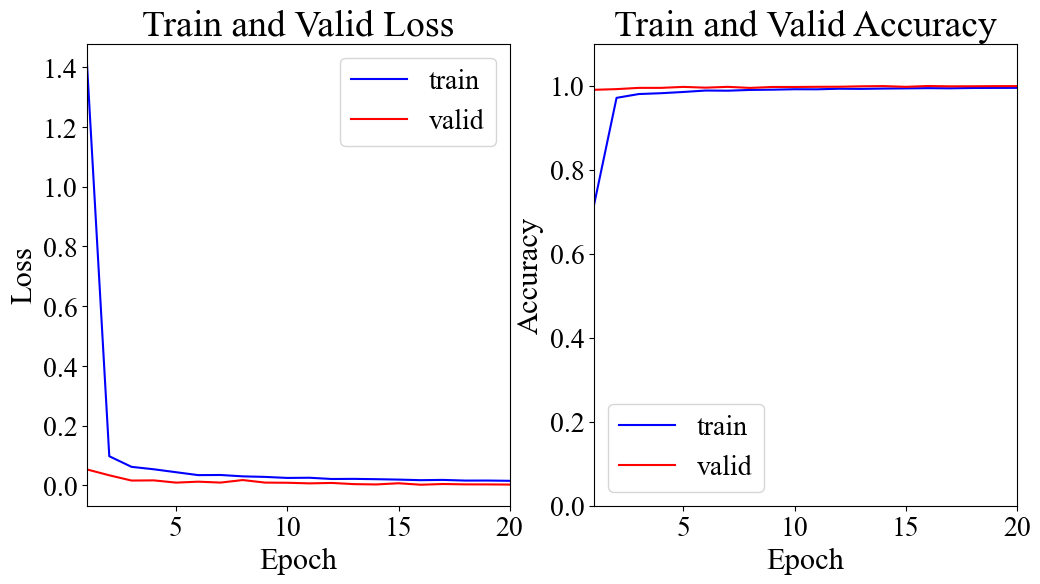

In [11]:
showTrainResult(model, 'Train and Valid')

In [12]:
def rank(prediction, masterKey, plaintext, keyBytesProba):
    # 0~255의 숫자별 옳은 키일 확률 구하기
    for guessKey in range(256):
        # 해당 pt와 키 연산 후 구한 중간값의 확률 저장
        proba = prediction[SBox[plaintext ^ guessKey]]
        # 옳은 키일 확률의 로그값 저장
        if proba != 0:
            # 0이 아닐 경우 중간값일 확률의 자연로그 값 저장
            keyBytesProba[guessKey] += np.log(proba)
        else:
            # 0이면 prediction 중에서 0이 아닌 값들 중 최소값 저장
            minProba = min(prediction[np.array(prediction) != 0])
            # 최소값의 제곱의 로그값 저장
            keyBytesProba[guessKey] += np.log(minProba ** 2)
    # 옳은 키 값의 순위 리턴 
    return np.where(np.sort(keyBytesProba)[::-1] == keyBytesProba[masterKey])[0][0], keyBytesProba

def fullRanks(model, trace, masterKey, plaintext, byte, testTraceNum):
    # 0~999의 무작위 값이 저장되어있는 1000개 숫자
    randomIndex = np.random.choice(len(trace), testTraceNum)
    # 파형 섞기
    testTrace = trace[randomIndex]     
    # 평문 섞기
    testPlain = plaintext[randomIndex]
    # 각 파형에 대해 모델이 예측한 중간값 확률을 predictions 배열에 저장
    predictions = np.array(model.predict(testTrace[:1000]))
    # 1000개의 파형 각각의 옳은 키 순위 저장하는 배열
    fullRank = np.zeros((len(testTrace)), dtype=np.uint32)
    # 256개 숫자 각각의 옳은 키일 확률
    keyBytesProba = np.zeros(256)
    for index in range(len(predictions)):
        # rank()함수로 얻은 정답 키의 순위 저장
        realKeyRank, keyBytesProba = rank(predictions[index], 
                                          masterKey[byte], 
                                          testPlain[index][byte], 
                                          keyBytesProba)
        # 해당 파형의 정답 키의 순위 저장
        fullRank[index] = realKeyRank
    return fullRank

def getRank(model, trace, masterKey, plaintext, byte, testTraceNum, testNum, title=''):
    # 크기가 1000인 배열로 초기화
    GE = np.zeros(testTraceNum, dtype=np.float64)
    SR = np.zeros(testTraceNum, dtype=np.float64)
    # testnum=10 만큼 반복
    for testIndex in tqdm.tqdm(range(testNum)): 
        # 파형별 옳은 키의 순위값 구하기
        rank = fullRanks(model, trace, masterKey, plaintext, byte, testTraceNum)
        # 옳은 키의 순위 값 더하기
        GE += rank
        # 옳은 키의 순위가 0인 경우(성공) 1 더하기
        SR += rank == 0
    # GE : 옳은 키의 평균 순위
    GE /= testNum
    # SR : 옳은 키를 맞춘 비율
    SR /= testNum
    
    return GE, SR

In [19]:
def showGESR(GE, SR):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(GE, color='k')
    plt.xlim(0, len(GE)-1)
    plt.ylim(-20, 256)
    plt.title('Guessing Entropy', fontsize=titleFontSize)
    
    plt.subplot(1, 2, 2)
    plt.plot(SR, color='k')
    plt.xlim(0, len(SR)-1)
    plt.ylim(0, 1.1)
    plt.title('Success Rate', fontsize=titleFontSize)
    
    plt.show()

In [20]:
GE, SR = getRank(model, normAttackTrace, attackKey[0], attackPlain, targetByte, testTraceNum=normAttackTrace.shape[0], testNum=10)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

32/32 [==============================] - 0s 2ms/step


 10%|████████▎                                                                          | 1/10 [00:01<00:17,  1.90s/it]

32/32 [==============================] - 0s 2ms/step


 20%|████████████████▌                                                                  | 2/10 [00:03<00:14,  1.87s/it]

32/32 [==============================] - 0s 2ms/step


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:13,  1.91s/it]

32/32 [==============================] - 0s 2ms/step


 40%|█████████████████████████████████▏                                                 | 4/10 [00:07<00:12,  2.01s/it]

32/32 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:10<00:10,  2.06s/it]

32/32 [==============================] - 0s 2ms/step


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:11<00:07,  2.00s/it]

32/32 [==============================] - 0s 2ms/step


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:13<00:05,  1.95s/it]

32/32 [==============================] - 0s 2ms/step


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:15<00:03,  1.93s/it]

32/32 [==============================] - 0s 2ms/step


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:17<00:01,  1.91s/it]

32/32 [==============================] - 0s 2ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


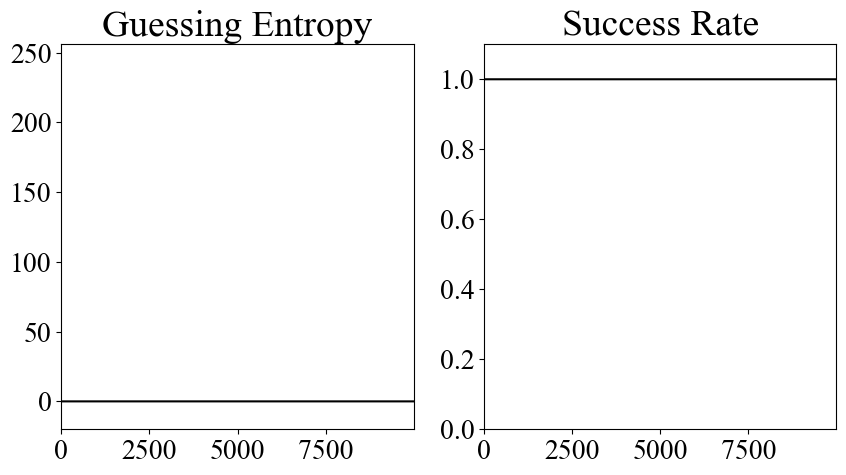

In [21]:
showGESR(GE, SR)